In [1]:
import argparse
import time
import numpy as np
from dataset import *
from models import * 
from generation import * 

from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DIR_PATH = "dataset/poems.csv"
SOV_TOKEN = "<SOV>" # start of verse
EOV_TOKEN = "<EOV>" # end of verse
encoder_ckpt = "saved_models/encoder_18.pt"
decoder_ckpt = "saved_models/decoder_18.pt"

parser = argparse.ArgumentParser()
parser.add_argument('--max_epochs', type=int, default=30)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--sequence_length', type=int, default=15)
args, unknown = parser.parse_known_args()

# Define the dataset and dataloader
dataset = SpanishPoemsDataset(DIR_PATH, SOV_TOKEN, EOV_TOKEN, args)
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

print(dataset.__getitem__(3))
print('Vocab:', len(dataset.unique_words))

(tensor([2449, 1375,    1,    0,    6,   15, 2450, 2451,    5,   66, 2452,    1,
           0,    5, 2453]), tensor([1375,    1,    0,    6,   15, 2450, 2451,    5,   66, 2452,    1,    0,
           5, 2453,   24]))
Vocab: 7506


**Detailed explanation**

The attention mechanism computes an "energy" score for each time step in the encoder outputs. To do this, it first repeats the decoder's hidden state along the time dimension to match the sequence length of the encoder outputs. This allows the attention mechanism to compare the decoder's hidden state with each time step's encoder output.

The energy score is obtained by concatenating the repeated decoder hidden state and the encoder outputs along the feature dimension. This concatenated tensor is passed through a linear layer (a single-layer neural network) with output size 1, which converts the tensor into a scalar value for each time step.

The context vector is the weighted sum of the encoder outputs based on the attention weights. It is computed by element-wise multiplying the attention scores with the encoder outputs and then summing them along the time dimension.

# TRAINING

In [3]:
# Set hyperparameters

input_size = len(dataset.unique_words) # size of the vocabulary for the input sequence
output_size = len(dataset.unique_words) # size of the vocabulary for the target sequence
hidden_size = 128
num_layers = 1
batch_size = args.batch_size
sequence_length = args.sequence_length
num_epochs = args.max_epochs
learning_rate = 0.001

# Instantiate the encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = GRUDecoderWithAttention(hidden_size, output_size, num_layers)

# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

In [4]:
start_time = time.time()
loss_history = []
encoder.train()
decoder.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch_inputs, batch_targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # batch_inputs = batch_inputs
        # batch_targets = batch_targets

        # Initialize the hidden state and cell state of the encoder
        hidden, cell_state = encoder.init_hidden(sequence_length)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass - Encoder
        encoder_outputs, (hidden, cell_state) = encoder(batch_inputs, (hidden, cell_state))  # Updated for LSTM

        # Initialize the hidden state of the decoder with the final encoder hidden state
        decoder_hidden = hidden[:, 1:sequence_length, :].contiguous()
        encoder_outputs = encoder_outputs[:, 1:sequence_length, :].contiguous()
        
        # Prepare the input and target sequences for the decoder
        decoder_inputs = batch_targets[:, :-1]
        decoder_targets = batch_targets[:, 1:]
        
        # Forward pass - Decoder with Attention
        decoder_outputs, _, attention_scores = decoder(decoder_inputs, decoder_hidden, encoder_outputs)

        # Calculate the loss
        loss = criterion(decoder_outputs.reshape(-1, output_size), decoder_targets.reshape(-1))

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Save the model after each epoch
    torch.save(encoder.state_dict(), encoder_ckpt)
    torch.save(decoder.state_dict(), decoder_ckpt)

    # Print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time/3600) 

Epoch 1/30: 100%|██████████| 323/323 [02:29<00:00,  2.16it/s]


Epoch 1/30, Loss: 5.7540


Epoch 2/30: 100%|██████████| 323/323 [02:28<00:00,  2.18it/s]


Epoch 2/30, Loss: 4.8992


Epoch 3/30: 100%|██████████| 323/323 [02:28<00:00,  2.18it/s]


Epoch 3/30, Loss: 4.5008


Epoch 4/30: 100%|██████████| 323/323 [02:27<00:00,  2.20it/s]


Epoch 4/30, Loss: 4.1293


Epoch 5/30: 100%|██████████| 323/323 [02:28<00:00,  2.17it/s]


Epoch 5/30, Loss: 3.8010


Epoch 6/30: 100%|██████████| 323/323 [02:22<00:00,  2.26it/s]


Epoch 6/30, Loss: 3.4974


Epoch 7/30: 100%|██████████| 323/323 [02:24<00:00,  2.24it/s]


Epoch 7/30, Loss: 3.2471


Epoch 8/30: 100%|██████████| 323/323 [02:23<00:00,  2.25it/s]


Epoch 8/30, Loss: 3.0067


Epoch 9/30: 100%|██████████| 323/323 [02:07<00:00,  2.54it/s]


Epoch 9/30, Loss: 2.7293


Epoch 10/30: 100%|██████████| 323/323 [02:06<00:00,  2.54it/s]


Epoch 10/30, Loss: 2.4966


Epoch 11/30: 100%|██████████| 323/323 [02:06<00:00,  2.55it/s]


Epoch 11/30, Loss: 2.2488


Epoch 12/30: 100%|██████████| 323/323 [02:06<00:00,  2.55it/s]


Epoch 12/30, Loss: 2.0059


Epoch 13/30: 100%|██████████| 323/323 [02:06<00:00,  2.55it/s]


Epoch 13/30, Loss: 1.7645


Epoch 14/30: 100%|██████████| 323/323 [02:06<00:00,  2.55it/s]


Epoch 14/30, Loss: 1.5507


Epoch 15/30: 100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch 15/30, Loss: 1.3672


Epoch 16/30: 100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch 16/30, Loss: 1.2135


Epoch 17/30: 100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch 17/30, Loss: 1.0862


Epoch 18/30: 100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch 18/30, Loss: 0.9743


Epoch 19/30: 100%|██████████| 323/323 [02:05<00:00,  2.56it/s]


Epoch 19/30, Loss: 0.8715


Epoch 20/30: 100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch 20/30, Loss: 0.7798


Epoch 21/30: 100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch 21/30, Loss: 0.6919


Epoch 22/30: 100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch 22/30, Loss: 0.6180


Epoch 23/30: 100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch 23/30, Loss: 0.6007


Epoch 24/30: 100%|██████████| 323/323 [02:03<00:00,  2.60it/s]


Epoch 24/30, Loss: 0.5216


Epoch 25/30: 100%|██████████| 323/323 [02:04<00:00,  2.60it/s]


Epoch 25/30, Loss: 0.4450


Epoch 26/30: 100%|██████████| 323/323 [02:03<00:00,  2.61it/s]


Epoch 26/30, Loss: 0.3906


Epoch 27/30: 100%|██████████| 323/323 [02:03<00:00,  2.61it/s]


Epoch 27/30, Loss: 0.3443


Epoch 28/30: 100%|██████████| 323/323 [02:03<00:00,  2.61it/s]


Epoch 28/30, Loss: 0.3052


Epoch 29/30: 100%|██████████| 323/323 [02:03<00:00,  2.61it/s]


Epoch 29/30, Loss: 0.2710


Epoch 30/30: 100%|██████████| 323/323 [02:03<00:00,  2.61it/s]

Epoch 30/30, Loss: 0.2445
Elapsed time:  1.093580393128925


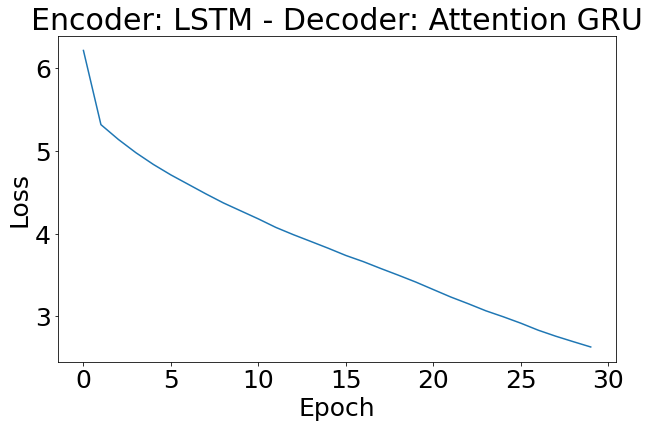

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 25
plt.figure(figsize=(10,6))
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Encoder: LSTM - Decoder: Attention GRU")
#plt.savefig("loss_512.jpg", bbox_inches='tight')
plt.show()

# GENERATE POEM 

In [62]:
poem, perplexity = generate_poem_GRU_with_attention(
    encoder, decoder, dataset, 
    0, 1, max_length=45, temperature=0.8, top_k=10, 
    encoder_ckpt=encoder_ckpt, 
    decoder_ckpt=decoder_ckpt
)


print('')
print(poem)
print('Perplexity: ', perplexity)


pero ha sido promulgado
un ardiente
no me deslumbres
me entiendes
ahora está aquí
en nuestro duelo inevitable
lo decíamos y queda
y me dicen tu boca
se evaporó
Perplexity:  10.347571543507414
